# Try models

In [1]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import lightgbm as lgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score, False)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df
data_raw = pd.read_csv('./data/air_visit_data.csv')
test = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
t = tag_data.set_index('index')
train_set = t[t.type == 0]
valid_set = t[t.type == 1]
train_set = train_set.reset_index().drop(['index', 'type'], axis=1)
valid_set = valid_set.reset_index().drop(['index', 'type'], axis=1)

len(train_set), len(train_set.air_store_id.unique()), len(valid_set), len(valid_set.air_store_id.unique())

(225049, 821, 25419, 821)

In [17]:
train_set.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2016-07-01,35
1,air_00a91d42b08b08d9,2016-07-02,9
2,air_00a91d42b08b08d9,2016-07-04,20
3,air_00a91d42b08b08d9,2016-07-05,25
4,air_00a91d42b08b08d9,2016-07-06,29


In [4]:
trn_data = utils.get_data(train_set)
X_train = trn_data['X']
y_train = trn_data['Y']
y_train_orig = trn_data['Y_org']
max_log_y = trn_data['max_log_y']
g_y_trn = trn_data['gadge']
contin_map_fit = trn_data['contin_map_fit']
cat_map_fit = trn_data['cat_map_fit']
all_vars = trn_data['all_vars']


val_data = utils.get_data(valid_set, contin_map_fit=contin_map_fit, cat_map_fit=cat_map_fit)
X_valid = val_data['X']
y_valid = val_data['Y']
y_valid_orig = val_data['Y_org']
g_y_valid = val_data['gadge']

/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:651: RuntimeWarning: invalid value encountered in log1p
  max_log_y = np.max(np.log1p(y_orig))
/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:652: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(y_orig) / max_log_y


In [44]:



all_vars



['genre_name',
 'air_store_id',
 'hpb_genre_name',
 'visit_date_year',
 'area_name',
 'stores_in_hpb_loc',
 'stores_in_hpb_area_name',
 'stores_in_area_name',
 'stores_in_air_loc',
 'prop_yhat',
 'prop_yhat_lower',
 'prop_yhat_upper']

In [ ]:
categorical_feature=cat_vars, 

In [5]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train.ravel(), feature_name=all_vars, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid.ravel(), reference=lgb_train, free_raw_data=False)

In [6]:
# specify your configurations as a dict
params = {
    'task': 'train',
#     'boosting_type': 'dart',
    'objective': 'regression',
#     'metric': {'mse'},
    'num_leaves': 50,
    'learning_rate': 0.08,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_bin': 15,
    'max_depth': 40
}
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=(lgb_train, lgb_eval),
                feval=rmsle_wo_log,
                evals_result=evals_result,
                ) # early_stopping_rounds=0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[1]	training's rmsle: 0.766591	valid_1's rmsle: 0.756959
[2]	training's rmsle: 0.731222	valid_1's rmsle: 0.721555
[3]	training's rmsle: 0.700045	valid_1's rmsle: 0.691977
[4]	training's rmsle: 0.672524	valid_1's rmsle: 0.666957
[5]	training's rmsle: 0.648323	valid_1's rmsle: 0.646097
[6]	training's rmsle: 0.62695	valid_1's rmsle: 0.627833
[7]	training's rmsle: 0.608243	valid_1's rmsle: 0.611261
[8]	training's rmsle: 0.593045	valid_1's rmsle: 0.599857
[9]	training's rmsle: 0.578681	valid_1's rmsle: 0.589509
[10]	training's rmsle: 0.566364	valid_1's rmsle: 0.581629
[11]	training's rmsle: 0.555602	valid_1's rmsle: 0.57507
[12]	training's rmsle: 0.546435	valid_1's rmsle: 0.570332
[13]	training's rmsle: 0.538676	valid_1's rmsle: 0.564643
[14]	training's rmsle: 0.531787	valid_1's rmsle: 0.561812
[15]	training's rmsle: 0.52585	valid_1's rmsle: 0.560134
[16]	training's rmsle: 0.520731	valid_1's rmsle: 0.557972
[17]	training's rmsle: 0.516422	valid_1's rmsle: 0.557599
[18]	training's rmsle: 0.5

[144]	training's rmsle: 0.488693	valid_1's rmsle: 0.570485
[145]	training's rmsle: 0.488679	valid_1's rmsle: 0.57048
[146]	training's rmsle: 0.488663	valid_1's rmsle: 0.570356
[147]	training's rmsle: 0.488646	valid_1's rmsle: 0.570219
[148]	training's rmsle: 0.488632	valid_1's rmsle: 0.570267
[149]	training's rmsle: 0.488617	valid_1's rmsle: 0.570296
[150]	training's rmsle: 0.488596	valid_1's rmsle: 0.570268
[151]	training's rmsle: 0.488585	valid_1's rmsle: 0.57019
[152]	training's rmsle: 0.488571	valid_1's rmsle: 0.570042
[153]	training's rmsle: 0.488553	valid_1's rmsle: 0.569985
[154]	training's rmsle: 0.48854	valid_1's rmsle: 0.569911
[155]	training's rmsle: 0.488529	valid_1's rmsle: 0.569888
[156]	training's rmsle: 0.488514	valid_1's rmsle: 0.569792
[157]	training's rmsle: 0.488499	valid_1's rmsle: 0.569811
[158]	training's rmsle: 0.48848	valid_1's rmsle: 0.569778
[159]	training's rmsle: 0.488466	valid_1's rmsle: 0.569796
[160]	training's rmsle: 0.488444	valid_1's rmsle: 0.569826
[

In [48]:
# ax = lgb.plot_metric(evals_result, metric='rmsle')
# ax = lgb.plot_importance(gbm, max_num_features=10)


In [7]:
def verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y):
    from sklearn import linear_model

    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    pred_valid = reg.predict(X_valid)
    pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
    # pred_valid_orig = pred_valid
    valid_loss = rmsle(pred_valid_orig, y_valid_orig)
    pred_trn = reg.predict(X_train)
    pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
    # pred_trn_orig = pred_trn
    trn_loss = rmsle(pred_trn_orig, y_train_orig)
#     plt.figure(1)
#     plt.plot(pred_valid_orig[:100], c='b')
#     plt.plot(y_valid_orig[:100], c='r')
    print('Linear Model train loss: {}, valid loss: {}'.format( trn_loss, valid_loss))
    return reg

reg = verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y)

y_train_orig = train_set.visitors.values

base_valid= rmsle(g_y_trn.values, y_train_orig.ravel())
base_trn= rmsle(g_y_valid.values, y_valid_orig.ravel())

print('Base line train loss {}, valid loss {}'.format(base_trn, base_valid))

# split_point = X.shape[0] - y_valid_orig.ravel().shape[0]
# base_line = rmsle(tidy_data['prop_yhat'].values[split_point:].ravel(), y_valid_orig.ravel())

pred_valid = gbm.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig.ravel())
pred_trn = gbm.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig.ravel())
print('LightBGM train loss: {}, valid loss: {}'.format(trn_loss, valid_loss))

# plt.figure(2)
# plt.plot(pred_valid_orig[:100], c='b')
# plt.plot(y_valid_orig[:100], c='r')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Linear Model train loss: 0.48906619608678153, valid loss: 0.5539458509582287
Base line train loss 0.48569097354010166, valid loss 0.48959534832409946
LightBGM train loss: 0.4878764655887996, valid loss: 0.5355351514348963


# Submit


In [8]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))

test_data = utils.get_data(trn_like_test, contin_map_fit=contin_map_fit, cat_map_fit=cat_map_fit)
X_tst= test_data['X']
y_tst = test_data['Y']
g_y_tst = test_data['gadge']

/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:651: RuntimeWarning: invalid value encountered in log1p
  max_log_y = np.max(np.log1p(y_orig))
/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:652: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(y_orig) / max_log_y


In [9]:

# pred_reg = utils.log_max_inv(reg.predict(X), max_log_y)
pred_gbm = utils.log_max_inv(gbm.predict(X_tst), max_log_y)

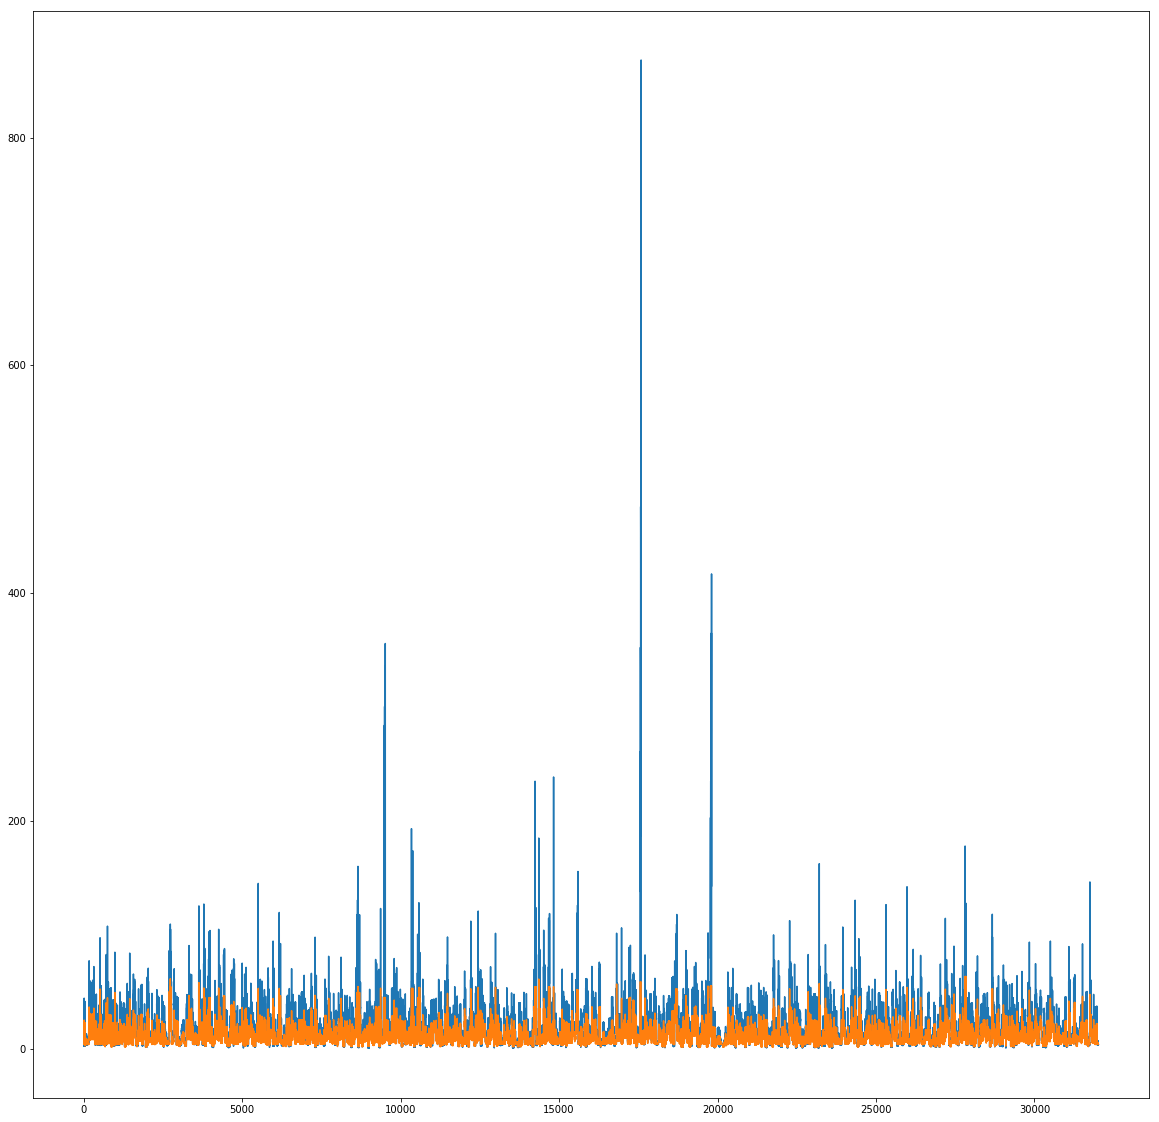

In [11]:
plt.plot(g_y_tst)
plt.plot(pred_gbm)

In [13]:
test.visitors = pred_gbm
test.to_csv('result/gbm.csv', index=False)
# test.visitors = pred_reg
# test.loc[test.visitors<0, "visitors"] = 0
# test.to_csv('result/reg.csv', index=False)